# Asset replacement model with maintenance

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demddp03.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

Consider the preceding example, but suppose that the productivity of the asset may be
enhanced by performing annual service maintenance. Specifically, at the beginning of each
year, a manufacturer must decide whether to replace the asset with a new one or, if he elects
to keep the asset, whether to service it. An asset that is $a$ years old and has been serviced $s$ times yields a profit contribution $p(a, s)$ up to an age of $n$ years, at which point the asset becomes unsafe and must be replaced by law. The cost of a new asset is $c$, and the cost of servicing an asset is $k$. What replacement-maintenance policy maximizes profits?

## Initial tasks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compecon import DDPmodel, gridmake, getindex

## Model Parameters
Assume a maximum asset age of 5 years, asset replacement cost $c = 75$, cost of servicing $k = 10$, and annual discount factor $\delta = 0.9$.

In [2]:
maxage  = 5
repcost = 75
mancost = 10
delta   = 0.9

### State Space

This is an infinite horizon, deterministic model with time $t$ measured in years. The state
variables

$a \in \{1, 2, 3, \dots, n\}$

$s \in \{0, 1, 2, \dots, n − 1\}$

are the age of the asset in years and the number of servicings it has undergone, respectively.

In [3]:
s1 = np.arange(1, 1 + maxage)   # asset age
s2 = s1 - 1                     # servicings
S  = gridmake(s1,s2)            # combined state grid
S1, S2 = S
n = S1.size                     # total number of states

Here, the set of possible asset ages and servicings are generated individually, and then a two-dimensional state grid is constructed by forming their Cartesian product using the CompEcon routine gridmake.

### Action Space
The action variable

$x \in \{\text{no action}, \text{service}, \text{replace}\}$

is the hold-replacement-maintenance decision.

In [4]:
X = np.array(['no action', 'service', 'replace'])  # vector of actions
m = len(X)                               # number of actions

### Reward Function
The reward function is
\begin{equation}
f (a, s, x) =
\begin{cases}
p(a, s),         &x = \text{no action}\\
p(0, 0) − c,     &x = \text{service}\\
p(a, s + 1) − k, &x = \text{replace}
\end{cases}
\end{equation}

Assuming a profit contribution $p(a) =
50 − 2.5a −2.5a^2$ that is a function of the asset age $a$ in years.

Here, the rows of the reward matrix, which
correspond to the three admissible decisions (no action, service, replace), are computed
individually.

In [5]:
f = np.zeros((m, n))
q = 50 - 2.5 * S1 - 2.5 * S1 ** 2
f[0] = q * np.minimum(1, 1 - (S1 - S2) / maxage)
f[1] = q * np.minimum(1, 1 - (S1 - S2 - 1) / maxage) - mancost
f[2] = 50 - repcost

### State Transition Function
The state transition function is
\begin{equation}
g(a, s, x) =
\begin{cases}
(a + 1, s),     &x = \text{no action}\\
    (1, 0),     &x = \text{service}\\
(a + 1, s + 1), &x = \text{replace}
\end{cases}
\end{equation}

Here, the routine ```getindex``` is used to find the index of the following period’s state.

In [6]:
g = np.empty_like(f)
g[0] = getindex(np.c_[S1 + 1, S2], S)
g[1] = getindex(np.c_[S1 + 1, S2 + 1], S)
g[2] = getindex(np.c_[1, 0], S)

# Model Structure

The value of asset of age $a$ that has undergone $s$ servicings satisfies the Bellman equation
\begin{equation}
V(a,s) = \max\{p(a,s) + \delta V(a+1,s),\quad p(a,s+1)−k + \delta V(a+1,s+1),
\quad p(0,0) − c + \delta V(1,0)\}
\end{equation}

where we set $p(n, s) = −\infty$ for all $s$ to enforce replacement of an asset of age $n$. The
Bellman equation asserts that if the manufacturer replaces an asset of age $a$ with servicings
$s$, he earns $p(0,0) − c$ over the coming year and begins the subsequent year with an asset
worth $V(1,0)$; if he services the asset, he earns $p(a, s + 1) − k$ over the coming year
and begins the subsequent year with an asset worth $V(a + 1, s + 1)$. As with the previous
example, the value $V(a, s)$ measures not only the current and future net earnings of the
asset, but also the net earnings of all future assets that replace it.

To solve and simulate this model, use the CompEcon class ```DDPmodel```. 

In [7]:
model = DDPmodel(f, g, delta)
model.solve()
   

A deterministic discrete state, discrete action, dynamic model.
There are 3 possible actions over 25 possible states

## Analysis

### Simulate Model
The paths are computed by performing q deterministic simulation of 12 years in duration using the ```simulate()``` method.

In [8]:
sinit = 0
nyrs = 12
t = np.arange(nyrs + 1)
spath, xpath = model.simulate(sinit, nyrs)

In [9]:
pd.Categorical(X[xpath], categories=X)

['service', 'service', 'no action', 'replace', 'service', ..., 'service', 'service', 'no action', 'replace', 'service']
Length: 13
Categories (3, object): ['no action', 'service', 'replace']

In [10]:
simul = pd.DataFrame({
    'Year': t,
    'Age of Asset': S1[spath],
    'Number of Servicings': S2[spath]}).set_index('Year')

simul['Action'] = pd.Categorical(X[xpath], categories=X)
simul

,Age of Asset,Number of Servicings,Action
Year,,,
0,1,0,service
1,2,1,service
2,3,2,no action
3,4,2,replace
4,1,0,service
5,2,1,service
6,3,2,no action
7,4,2,replace
8,1,0,service


### Plot State Paths (Age and Servicings) and Action Path
The asset is replaced every four years, and is serviced twice, at the beginning of the second and third years of operation.

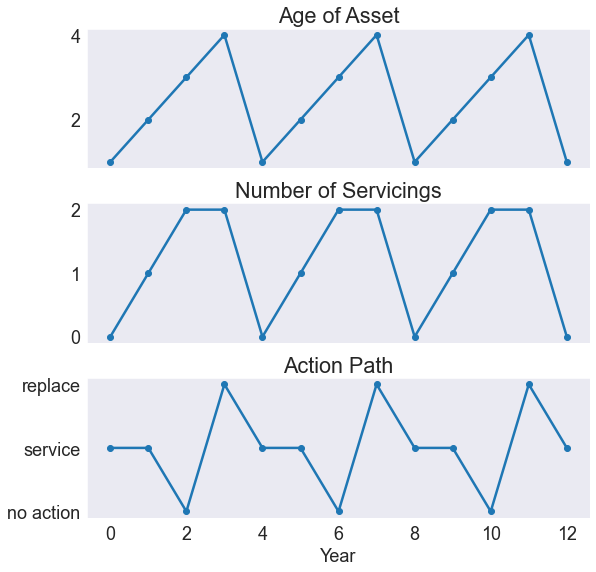

In [11]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=[9,9])
simul['Age of Asset'].plot(marker='o', ax=axs[0])
axs[0].set(title='Age of Asset')

simul['Number of Servicings'].plot(marker='o', ax=axs[1])
axs[1].set(title='Number of Servicings')

simul['Action'].cat.codes.plot(marker='o', ax=axs[2])
axs[2].set(title='Action Path', yticks=range(3), yticklabels=X);